# 1. Chargement des librairies et données

## 1.1. Import des librairies

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

## 1.2. Import des données

In [246]:
dataset = pd.read_csv("./dataset/insurance.csv")
df = pd.DataFrame(dataset)

display(df.head())

# Définition de la fonction section pour structurer l'affichage
def section(title):
    print("\n" + "="*60)
    print(title)
    print("="*60 + "\n")

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 1.3. Nettoyage des données

In [247]:
section("Traitement des doublons")
print(" Nombre de lignes dupliquées : ", df.duplicated().sum(), "\n")

display(df[df.duplicated(keep=False)])

df = df.drop_duplicates()
print("\n→ Doublons supprimés !")

section("Données manquantes")
display(df.isna().sum())
print("\n→ Pas de données manquantes")


Traitement des doublons

 Nombre de lignes dupliquées :  1 



,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631



→ Doublons supprimés !

Données manquantes



age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


→ Pas de données manquantes


# 2. Automatisation de la modélisation

## 2.1. Split test-train

In [248]:
def split_data(df):
    X = df.drop("charges", axis=1)
    y = df["charges"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size = 0.2,
        random_state = 42,
        stratify = df["smoker"]
    )

    return X_train, X_test, y_train, y_test

## 2.3. Sauvegarde et chargement de modèle

In [249]:
def save_model(id, pipeline):
    filename = f"./models/linear_model_{id}.sav"
    joblib.dump(pipeline, open(filename, "wb")) # write in binary, overrides if file already exists


def load_model(filename):
    loaded_model = joblib.load(open(f"./models/{filename}", "rb")) # read binary file
    return loaded_model

## 2.3. Transformation des données

In [250]:
def transform_columns(X_set):
    cat_cols = X_set.select_dtypes(include="object").columns.tolist()
    cat_cols_index = X_set.columns.get_indexer(cat_cols)

    num_cols = X_set.select_dtypes(include=["float64", "int64"]).columns.tolist()
    num_cols_index = X_set.columns.get_indexer(num_cols)

    preprocessor = ColumnTransformer(transformers = [("ohe_sex_smoker_children", OneHotEncoder(drop="first"), cat_cols_index),
                                                    ("standard_age_bmi_children", StandardScaler(), num_cols_index)
                                                    ])

    return preprocessor


def apply_pipeline(X_train, y_train, filename):

    preprocessor = transform_columns(X_train)

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("predictor", LinearRegression())
    ])

    pipeline.fit(X_train, y_train)

    save_model(filename, pipeline)

    return pipeline


## 2.4. Évaluation et visualisation des prédictions

In [251]:
def make_predictions(model, X_test):
    y_pred = model.predict(X_test)
    return y_pred


def visualise_predictions(y_test, y_pred, r2):
    plt.figure(figsize=(10, 6))

    plt.scatter(y_test, y_pred, alpha=0.6, edgecolors="k", linewidth=0.5, label="Prédictions")

    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             "r-", lw=2, label="Régression parfaite")

    plt.xlabel("Valeurs réelles", fontsize=12)
    plt.ylabel("Valeurs prédites", fontsize=12)
    plt.title(f"Régression linéaire (précision : {r2 * 100:.2f} %)", fontsize=12, fontweight="bold")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def evaluate_model(y_test, y_pred):
    titles = ["R2", "MAE", "MSE"]

    r2 = r2_score(y_test, y_pred)

    scores = [
        r2,
        np.mean(np.abs(y_test - y_pred)),
        (mean_squared_error(y_test, y_pred)) ** 0.5
    ]

    df_scores = pd.DataFrame([scores], columns=titles)

    print(f"\nMesures de performance :")
    
    display(df_scores.round(4))

    return r2


def run_model(model, X_test, y_test):
    y_pred = make_predictions(model, X_test)

    r2 = evaluate_model(y_test, y_pred)

    visualise_predictions(y_test, y_pred, r2)


# 3. Exécution de modèles


Mesures de performance :


,R2,MAE,MSE
0,0.8205,3592.7926,5086.8799


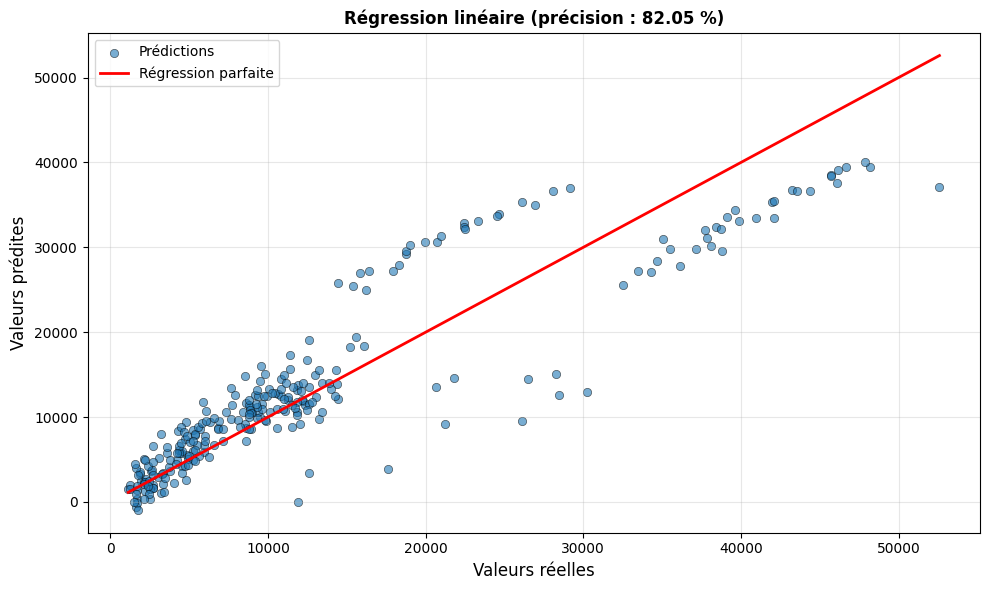

In [252]:
def linear_regression(df, filename, load=False):

    X_train, X_test, y_train, y_test = split_data(df)

    model = load_model(filename) if load else apply_pipeline(X_train, y_train, filename)

    run_model(model, X_test, y_test)

linear_regression(df, "linear_model_basic_1.sav", True)